In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import pandas as pd
import scipy as scp

import utils.pc_utils as pc
import utils.distributions as dsts
import utils.imread_utils as imr
import utils.calc_entropy as cen

import imp
imp.reload(imr)

#jupyter notebook settings
#%matplotlib inline
%config InlineBackend.print_figure_kwargs = {'dpi' : 200} #plotting pretty

In [2]:
#some settings for the dataset
p65folder = './images/places365/'
imfolder = p65folder+'val_large/'
imname = 'Places365_val_'
crop_size = (512,512)

## Load in Image Metadata 

### Match Filenames to Category ID

In [3]:
colnames = ['filename','category_ID']
df_fname_cid = pd.read_table(p65folder+'places365_val.txt',sep=' ',header=None,names=colnames)
df_fname_cid.head(5)

,filename,category_ID
0,Places365_val_00000001.jpg,165
1,Places365_val_00000002.jpg,358
2,Places365_val_00000003.jpg,93
3,Places365_val_00000004.jpg,164
4,Places365_val_00000005.jpg,289


### Match Category ID to Category Name

In [4]:
colnames = ['category','category_ID']
df_cat_cid = pd.read_table(p65folder+'categories_places365.txt',sep=' ',header=None,names=colnames)
df_cat_cid.head(5)

,category,category_ID
0,/a/airfield,0
1,/a/airplane_cabin,1
2,/a/airport_terminal,2
3,/a/alcove,3
4,/a/alley,4


### Match Category Name to Indoor/Outdoor Manmade/Natural Labels

In [5]:
df_cat_lab = pd.read_csv(p65folder+'SceneHierarchy_Places365.csv', header=1)
df_cat_lab = df_cat_lab.iloc[:, 0:4] #don't need more specific than indoor/outdoor manmade/natural
df_cat_lab.head(5)

,category,indoor,"outdoor, natural","outdoor, man-made"
0,'/a/airfield',0,0,1
1,'/a/airplane_cabin',1,0,0
2,'/a/airport_terminal',1,0,0
3,'/a/alcove',1,0,0
4,'/a/alley',0,0,1


### Put these into one easy-to-use table together

In [6]:
df = pd.concat([df_cat_cid, df_cat_lab.iloc[:,1:]], axis=1)
df = pd.merge(df_fname_cid, df, on=['category_ID']).sort_values('filename')
df.head(5)

,filename,category_ID,category,indoor,"outdoor, natural","outdoor, man-made"
0,Places365_val_00000001.jpg,165,/g/greenhouse/indoor,1,0,0
100,Places365_val_00000002.jpg,358,/w/wet_bar,1,0,0
200,Places365_val_00000003.jpg,93,/c/clean_room,1,0,0
300,Places365_val_00000004.jpg,164,/g/golf_course,0,1,1
400,Places365_val_00000005.jpg,289,/r/rock_arch,0,1,0


## Some Example Images

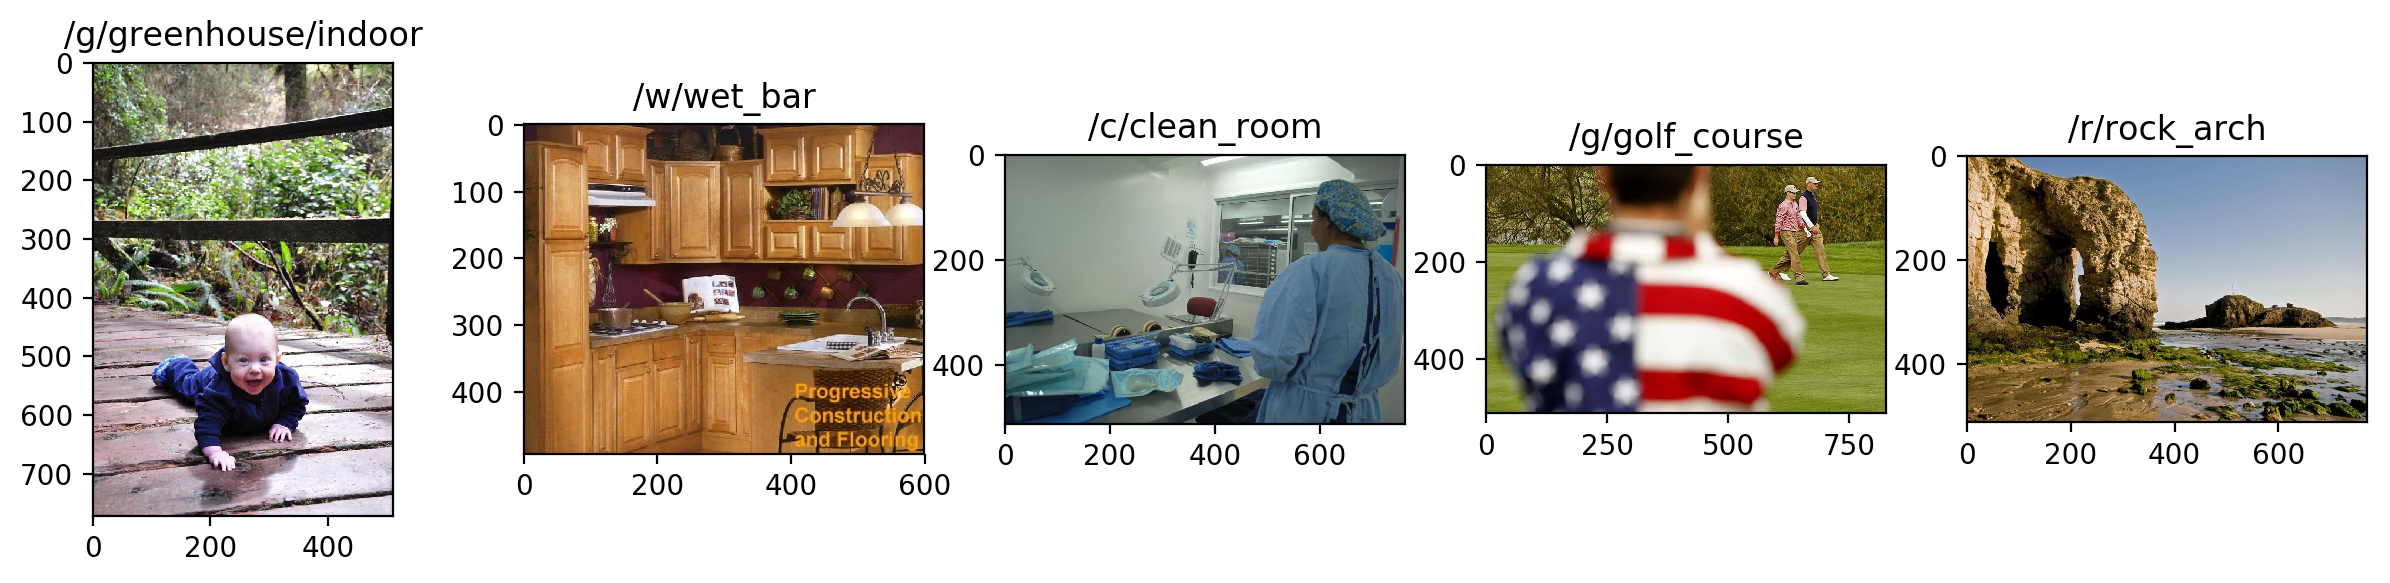

In [7]:
plt.figure(figsize=(15,3))
nims = 5

for imn in range(nims):
    imn = imn+1
    testim_fname = imname+'0000000'+str(imn)+'.jpg'
    testim = imr.readin_im(testim_fname, imfolder)
    testim_cat = df.loc[df['filename'] == testim_fname,'category'].item()
    #print(testim_cat)
    plt.subplot(1,nims,imn)
    plt.imshow(testim)
    plt.title(testim_cat)


## Get Indoor and Outdoor Images for Analysis

### nims = 500 #only take a subset of the data

#Indoor Image Filenames
indoor_fnames = df.loc[df['indoor'] == 1] #labeled as indoor
indoor_fnames = indoor_fnames.loc[(indoor_fnames['outdoor, natural'] == 0) & \
                       (indoor_fnames['outdoor, man-made'] == 0)] #not labeled as outdoor  
indoor_fnames = np.array(indoor_fnames['filename'].sample(n=nims+int(0.8*nims),replace=False)) #first n plus a few more that are below crop

#Outdoor Manmade Image Filenames
outdoorman_fnames = df.loc[(df['outdoor, natural'] == 0) & \
                       (df['outdoor, man-made'] == 1)]
outdoorman_fnames = outdoorman_fnames.loc[outdoorman_fnames['indoor'] == 0] # not labeled as indoor
outdoorman_fnames = np.array(outdoorman_fnames['filename'].sample(n=nims+int(0.08*nims),replace=False)) #first n

#Outdoor Natural Image Filenames
outdoornat_fnames = df.loc[(df['outdoor, natural'] == 1) & \
                       (df['outdoor, man-made'] == 0)]
outdoornat_fnames = outdoornat_fnames.loc[outdoornat_fnames['indoor'] == 0] #not labeled as indoor
outdoornat_fnames = np.array(outdoornat_fnames['filename'].sample(n=nims+int(0.08*nims),replace=False)) #first n

#readin images (preprocessing included but NO cosine window)
print('Reading in...')
indoor_ims = imr.readpreprc_ims(indoor_fnames, imfolder, cosine=False, crop=crop_size)[:nims]
outdoorman_ims = imr.readpreprc_ims(outdoorman_fnames, imfolder, cosine=False, crop=crop_size)[:nims]
outdoornat_ims = imr.readpreprc_ims(outdoornat_fnames, imfolder, cosine=False, crop=crop_size)[:nims]
print('Done!')

#control A: 1/f amplitude, random phase images
onef_ims = [dsts.make_onef_ims(crop_size, alpha=1, k=1) for i in range(nims)]

#control B: uniform random images
random_ims = [np.random.rand(*crop_size) for i in range(nims)]

#control c: gaussian random images
gauss_ims = [np.random.randn(*crop_size) for i in range(nims)]
gauss_ims = (gauss_ims - np.min(gauss_ims)) / (np.max(gauss_ims) - np.min(gauss_ims))

NameError: name 'indoor_ims' is not defined

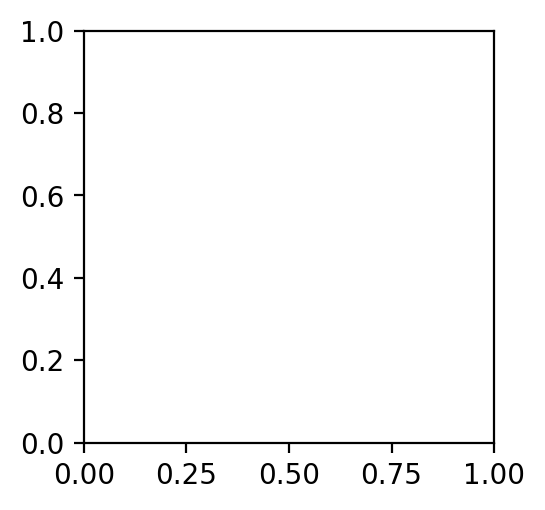

In [8]:
imnnum = 1
plt.figure(figsize=(9,6))
plt.subplot(2,3,1)
plt.imshow(indoor_ims[imnnum],cmap='Greys_r')
plt.axis('off')
#plt.colorbar()
plt.title('indoor')
plt.subplot(2,3,2)
plt.imshow(outdoorman_ims[imnnum],cmap='Greys_r')
plt.axis('off')
#plt.colorbar()
plt.title('outdoor manmade')
plt.subplot(2,3,3)
plt.imshow(outdoornat_ims[imnnum],cmap='Greys_r')
plt.axis('off')
#plt.colorbar()
plt.title('outdoor natural')
plt.subplot(2,3,4)
plt.imshow(onef_ims[imnnum],cmap='Greys_r')
plt.axis('off')
#plt.colorbar()
plt.title('1/f noise')
plt.subplot(2,3,5)
plt.imshow(random_ims[imnnum],cmap='Greys_r')
plt.axis('off')
#plt.colorbar()
plt.title('uniform noise')
plt.subplot(2,3,6)
plt.imshow(gauss_ims[imnnum],cmap='Greys_r')
plt.axis('off')
#plt.colorbar()
plt.title('gaussian noise')
#plt.colorbar()

### calcuate phase congruency directional mean for categories

In [ ]:
if 'gaus_pc_slope' not in locals():
    
    print('Calculating Indoor PC...')
    #indoor_pc_v = [pc.measure_pc_axis(im,axis=0) for im in indoor_ims]
    #indoor_pc_h = [pc.measure_pc_axis(im,axis=1) for im in indoor_ims]
    indoor_pc_v_means = [np.mean(pc) for pc in [pc.measure_pc_axis(im,axis=0) for im in indoor_ims]]
    indoor_pc_h_means = [np.mean(pc) for pc in [pc.measure_pc_axis(im,axis=1) for im in indoor_ims]]
    indoor_pc_slope, indoor_pc_offset = np.polyfit(indoor_pc_h_means, indoor_pc_v_means, deg=1)
    indoor_pc = np.array([pc.measure_pc_2d(im) for im in indoor_ims])

    print('Calculating Outdoor Manmade PC...')
    #outdoorman_pc_v = [pc.measure_pc_axis(im,axis=0) for im in outdoorman_ims]
    #outdoorman_pc_h = [pc.measure_pc_axis(im,axis=1) for im in outdoorman_ims]
    outdoorman_pc_v_means = [np.mean(pc) for pc in [pc.measure_pc_axis(im,axis=0) for im in outdoorman_ims]]
    outdoorman_pc_h_means = [np.mean(pc) for pc in [pc.measure_pc_axis(im,axis=1) for im in outdoorman_ims]]
    outdoorman_pc_slope, outdoorman_pc_offset = np.polyfit(outdoorman_pc_h_means, outdoorman_pc_v_means, deg=1)
    outdoorman_pc = np.array([pc.measure_pc_2d(im) for im in outdoorman_ims])

    print('Calculating Outdoor Natural PC...')
    #outdoornat_pc_v = [pc.measure_pc_axis(im,axis=0) for im in outdoornat_ims] 
    #outdoornat_pc_h = [pc.measure_pc_axis(im,axis=1) for im in outdoornat_ims] 
    outdoornat_pc_v_means = [np.mean(pc) for pc in [pc.measure_pc_axis(im,axis=0) for im in outdoornat_ims]]
    outdoornat_pc_h_means = [np.mean(pc) for pc in [pc.measure_pc_axis(im,axis=1) for im in outdoornat_ims]]
    outdoornat_pc_slope, outdoornat_pc_offset = np.polyfit(outdoornat_pc_h_means, outdoornat_pc_v_means, deg=1)
    outdoornat_pc = np.array([pc.measure_pc_2d(im) for im in outdoornat_ims])

    print('Calculating 1/f Noise PC...')
    #onef_pc_v = [pc.measure_pc_axis(im,axis=0) for im in onef_ims]
    #onef_pc_h = [pc.measure_pc_axis(im,axis=1) for im in onef_ims]
    onef_pc_v_means = [np.mean(pc) for pc in [pc.measure_pc_axis(im,axis=0) for im in onef_ims]]        
    onef_pc_h_means = [np.mean(pc) for pc in [pc.measure_pc_axis(im,axis=1) for im in onef_ims]]        
    onef_pc_slope, onef_pc_offset = np.polyfit(onef_pc_h_means, onef_pc_v_means, deg=1)
    onef_pc = np.array([pc.measure_pc_2d(im) for im in onef_ims])

    print('Calculating Uniform Noise PC...')
    #rand_pc_v = [pc.measure_pc_axis(im,axis=0) for im in random_ims]
    #rand_pc_h = [pc.measure_pc_axis(im,axis=1) for im in random_ims]
    rand_pc_v_means = [np.mean(pc) for pc in [pc.measure_pc_axis(im,axis=0) for im in random_ims]]        
    rand_pc_h_means = [np.mean(pc) for pc in [pc.measure_pc_axis(im,axis=1) for im in random_ims]]    
    rand_pc_slope, rand_pc_offset = np.polyfit(rand_pc_h_means, rand_pc_v_means, deg=1)
    rand_pc = np.array([pc.measure_pc_2d(im) for im in random_ims])

    print('Calculating Gaussian Noise PC...')
    #gaus_pc_v = [pc.measure_pc_axis(im,axis=0) for im in gauss_ims]
    #gaus_pc_h = [pc.measure_pc_axis(im,axis=1) for im in gauss_ims]
    gaus_pc_v_means = [np.mean(pc) for pc in [pc.measure_pc_axis(im,axis=0) for im in gauss_ims]]        
    gaus_pc_h_means = [np.mean(pc) for pc in [pc.measure_pc_axis(im,axis=1) for im in gauss_ims]]    
    gaus_pc_slope, gaus_pc_offset = np.polyfit(gaus_pc_h_means, gaus_pc_v_means, deg=1)
    gaus_pc = np.array([pc.measure_pc_2d(im) for im in gauss_ims])

    print('Done!')

In [ ]:
plt.figure(figsize=(10,5))

plt.subplot(2,3,1)
plt.imshow(pc.measure_pc_axis(indoor_ims[1],axis=0),cmap='Greys_r')
plt.title('Vertical PC')
plt.axis('off')
plt.subplot(2,3,4)
plt.imshow(pc.measure_pc_axis(indoor_ims[1],axis=1),cmap='Greys_r')
plt.title('Horizontal PC')
plt.axis('off')
plt.subplot(2,3,2)
plt.imshow(pc.measure_pc_axis(outdoorman_ims[1],axis=0),cmap='Greys_r')
plt.title('Vertical PC')
plt.axis('off')
plt.subplot(2,3,5)
plt.imshow(pc.measure_pc_axis(outdoorman_ims[1],axis=1),cmap='Greys_r')
plt.title('Horizontal PC')
plt.axis('off')
plt.subplot(2,3,3)
plt.imshow(pc.measure_pc_axis(outdoornat_ims[1],axis=0),cmap='Greys_r')
plt.title('Vertical PC')
plt.axis('off')
plt.subplot(2,3,6)
plt.imshow(pc.measure_pc_axis(outdoornat_ims[1],axis=1),cmap='Greys_r')
plt.title('Horizontal PC')
plt.axis('off')
plt.tight_layout

In [ ]:
mxf = np.max(indoor_pc_v_means)
fran = np.linspace(0,mxf,100)

ss = 5
al = 0.3

#1:1 line
plt.plot(fran,fran,  c='grey', linestyle='--')

#outdoor natural
plt.scatter(outdoornat_pc_h_means, outdoornat_pc_v_means, s=ss, alpha = al,
            label='outdoor_nat: {:.2f}'.format(np.mean(outdoornat_pc_slope)))
plt.plot(fran, fran*outdoornat_pc_slope+outdoornat_pc_offset)

#indoor
plt.scatter(indoor_pc_h_means, indoor_pc_v_means, s=ss, alpha = al,
            label='indoor: {:.2f}'.format(np.mean(indoor_pc_slope)))
plt.plot(fran, fran*indoor_pc_slope+indoor_pc_offset)  

#outdoor manmade
plt.scatter(outdoorman_pc_h_means, outdoorman_pc_v_means, s=ss, alpha = al,
            label='outdoor_man: {:.2f}'.format(np.mean(outdoorman_pc_slope)))
plt.plot(fran, fran*outdoorman_pc_slope+outdoorman_pc_offset)


#1/f noise
plt.scatter(onef_pc_h_means, onef_pc_v_means, s=ss, alpha = al,
            label='onef: {:.2f}'.format(np.mean(onef_pc_slope)))
plt.plot(fran, fran*onef_pc_slope+onef_pc_offset)

#uniform
# plt.scatter(rand_pc_h_means, rand_pc_v_means, s=ss, alpha = al,
#            label='unif: {:.2f}'.format(np.mean(rand_pc_slope)))
# plt.plot(fran, fran*rand_pc_slope+rand_pc_offset)

#gaussian
#plt.scatter(gaus_pc_h_means, gaus_pc_v_means, s=ss, alpha = al,
#            label='gauss: {:.2f}'.format(np.mean(gaus_pc_slope)))
#plt.plot(fran, fran*gaus_pc_slope+gaus_pc_offset)


plt.xlabel('Horizontal PC')
plt.ylabel('Vertical PC')
plt.legend()
plt.title('Mean Axial PC')

#plt.gca().set_aspect('equal', adjustable='box')

In [ ]:
indoor_pc_slope, indoor_pc_offset = np.polyfit(indoor_pc_v_means, indoor_pc_h_means, deg=1)
outdoorman_pc_slope, outdoorman_pc_offset = np.polyfit(outdoorman_pc_v_means, outdoorman_pc_h_means, deg=1)
outdoornat_pc_slope, outdoornat_pc_offset = np.polyfit(outdoornat_pc_v_means, outdoornat_pc_h_means, deg=1)

In [ ]:
plt.figure(figsize=(12,3))
plt.boxplot((indoor_pc_h_means, indoor_pc_v_means,
             outdoorman_pc_h_means,outdoorman_pc_v_means,
             outdoornat_pc_h_means,outdoornat_pc_v_means,
             onef_pc_h_means, onef_pc_v_means,
             rand_pc_h_means, rand_pc_h_means,
             gaus_pc_h_means, gaus_pc_h_means),
           labels=('indoor_h', 'indoor_v',
                    'outman_h','outman_v',
                    'outnat_h','outnat_v',
                    'onef_h','onef_v',
                    'unif_h','unif_v',
                    'gaus_h','gaus_v'));

plt.title('Horizontal & Vertical Phase Congruency')

In [ ]:
plt.figure(figsize=(4,4))
indoor_rats = np.divide(indoor_pc_v_means,indoor_pc_h_means)
outdoorman_rats = np.divide(outdoorman_pc_v_means,outdoorman_pc_h_means)
outdoornat_rats = np.divide(outdoornat_pc_v_means,outdoornat_pc_h_means)
plt.boxplot((indoor_rats, outdoorman_rats, outdoornat_rats),
           labels=('indoor','outdoor_man','outoor_nat'))
plt.axhline(1,c='grey', linestyle='--',linewidth=0.5)
#plt.yscale('log')
plt.ylabel('Vertical/Horizontal Ratio')
plt.title('Vertical/Horizontal PC Ratio by Category')

In [ ]:
ax = plt.boxplot((indoor_pc.flatten(),
             outdoorman_pc.flatten(),
             outdoornat_pc.flatten(),
             onef_pc.flatten(),
             rand_pc.flatten(),
             gaus_pc.flatten()),
             labels=('Indoor',
                    'Out_Man',
                    'Out_Nat',
                    'OneF',
                    'Unif',
                    'Gaus'));

plt.yscale('log')
plt.title('Total Phase Congruency')

In [ ]:
nbins = 500
plt.figure(figsize=(10,7))
plt.subplot(2,3,1)
plt.hist(np.array(indoor_pc).flatten(),log='y',bins=nbins)
plt.title('Indoor PC Dist')
plt.subplot(2,3,2)
plt.hist(np.array(outdoorman_pc).flatten(),log='y',bins=nbins)
plt.title('Outdoor Nat PC Dist')
plt.subplot(2,3,3)
plt.hist(np.array(outdoornat_pc).flatten(),log='y',bins=nbins)
plt.title('Outdoor Man PC Dist')
plt.subplot(2,3,4)
plt.hist(np.array(onef_pc).flatten(),log='y',bins=nbins)
plt.title('1/f PC Dist')
plt.subplot(2,3,5)
plt.hist(np.array(rand_pc).flatten(),log='y',bins=nbins)
plt.title('Uniform PC Dist')
plt.subplot(2,3,6)
plt.hist(np.array(gaus_pc).flatten(),log='y',bins=nbins)
plt.title('Gaussian PC Dist')
plt.tight_layout()

In [ ]:
alp = 0.8
plt.hist(outdoornat_pc.flatten(),log='y',bins=nbins, alpha = alp,
        label='outdoor_natural: $\mu$={:.3f}'.format(np.mean(outdoornat_pc)));
plt.hist(indoor_pc.flatten(),log='y',bins=nbins, alpha = alp,
        label='indoor: $\mu$={:.3f}'.format(np.mean(indoor_pc)));
plt.hist(outdoorman_pc.flatten(),log='y',bins=nbins, alpha = alp,
        label='outdoor_manmade: $\mu$={:.3f}'.format(np.mean(outdoorman_pc)));
plt.title('Image PC by category')
plt.xlabel('Phase Congruency')
plt.ylabel('Log Occurances')
plt.legend()

In [ ]:
alp = 0.8
plt.hist(outdoornat_pc.flatten(),log='y',bins=nbins, alpha = alp,
        label='outdoor_natural: $\mu$={:.3f}'.format(np.mean(outdoornat_pc)));
plt.hist(indoor_pc.flatten(),log='y',bins=nbins, alpha = alp,
        label='indoor: $\mu$={:.3f}'.format(np.mean(indoor_pc)));
plt.hist(outdoorman_pc.flatten(),log='y',bins=nbins, alpha = alp,
        label='outdoor_manmade: $\mu$={:.3f}'.format(np.mean(outdoorman_pc)));

plt.hist(onef_pc.flatten(),log='y',bins=nbins, alpha = alp,
        label='1/f: $\mu$={:.3f}'.format(np.mean(onef_pc)));
plt.hist(gaus_pc.flatten(),log='y',bins=nbins, alpha = alp,
        label='gaussian: $\mu$={:.3f}'.format(np.mean(gaus_pc)));
plt.hist(rand_pc.flatten(),log='y',bins=nbins, alpha = alp,
        label='uniform: $\mu$={:.3f}'.format(np.mean(rand_pc)));

plt.title('Phase Congruency Distribution by Category')
plt.xlabel('Phase Congruency')
plt.ylabel('Log Occurances')
plt.legend()

In [ ]:
logflag = False
nbins=100
alp = 0.8
plt.hist(np.mean(outdoornat_pc,axis=(1,2)),log=logflag,bins=nbins, alpha = alp,
        label='outdoor_natural: $\mu$={:.3f}'.format(np.mean(outdoornat_pc)));
plt.hist(np.mean(indoor_pc,axis=(1,2)),log=logflag,bins=nbins, alpha = alp,
        label='indoor: $\mu$={:.3f}'.format(np.mean(indoor_pc)));
plt.hist(np.mean(outdoorman_pc,axis=(1,2)),log=logflag,bins=nbins, alpha = alp,
        label='outdoor_manmade: $\mu$={:.3f}'.format(np.mean(outdoorman_pc)));

plt.hist(np.mean(onef_pc,axis=(1,2)),log=logflag,bins=nbins, alpha = alp,
        label='1/f: $\mu$={:.3f}'.format(np.mean(onef_pc)));
plt.hist(np.mean(gaus_pc,axis=(1,2)),log=logflag,bins=nbins, alpha = alp,
        label='gaussian: $\mu$={:.3f}'.format(np.mean(gaus_pc)));
plt.hist(np.mean(rand_pc,axis=(1,2)),log=logflag,bins=nbins, alpha = alp,
        label='uniform: $\mu$={:.3f}'.format(np.mean(rand_pc)));

plt.title('Image Mean Phase Congruency Distribution by Category')
plt.xlabel('Mean Phase Congruency')
plt.ylabel('Occurances')
plt.legend()

## Fourier Transform of PC

In [ ]:
indoor_pc_fts = np.array([np.fft.fftshift(np.fft.fft2(imr.cosine_window(im))) for im in indoor_pc])
outdoornat_pc_fts = np.array([np.fft.fftshift(np.fft.fft2(imr.cosine_window(im))) for im in outdoornat_pc])
outdoorman_pc_fts = np.array([np.fft.fftshift(np.fft.fft2(imr.cosine_window(im))) for im in outdoorman_pc])
onef_pc_fts = np.array([np.fft.fftshift(np.fft.fft2(imr.cosine_window(im))) for im in onef_pc])
rand_pc_fts = np.array([np.fft.fftshift(np.fft.fft2(imr.cosine_window(im))) for im in rand_pc])
gaus_pc_fts = np.array([np.fft.fftshift(np.fft.fft2(imr.cosine_window(im))) for im in gaus_pc])

In [ ]:
imnum = 30

plt.figure(figsize=(10,6))

plt.subplot(2,3,1)
plt.imshow(outdoornat_ims[imnum],cmap='Greys_r')
plt.colorbar()

imft = np.fft.fftshift(np.fft.fft2(imr.cosine_window(outdoornat_ims[imnum])))

plt.subplot(2,3,2)
plt.imshow(np.log(np.abs(imft)))
plt.colorbar()

plt.subplot(2,3,3)
plt.imshow(np.real(np.angle(imft)))
plt.colorbar()

plt.subplot(2,3,4)
plt.imshow(outdoornat_pc[imnum],cmap='Greys_r')
plt.colorbar()

plt.subplot(2,3,5)
plt.imshow(np.log(np.abs(outdoornat_pc_fts[imnum])))
plt.colorbar()

plt.subplot(2,3,6)
plt.imshow(np.real(np.angle(outdoornat_pc_fts[imnum])))
plt.colorbar()

plt.tight_layout()


## Calculate entropy 

In [ ]:
imp.reload(cen)
#clear memory before filling it up more
entropy = True
if(entropy):
#     del indoor_pc
#     del outdoorman_pc
#     del outdoornat_pc
#     del onef_pc
#     del rand_pc
#     del gaus_pc
    
    indoor_entropys = np.array([cen.calc_entropy(im) for im in indoor_ims])
    outdoorman_entropys = np.array([cen.calc_entropy(im) for im in outdoorman_ims])
    outdoornat_entropys = np.array([cen.calc_entropy(im) for im in outdoornat_ims])
    onef_entropys = np.array([cen.calc_entropy(im) for im in onef_ims])
    rand_entropys = np.array([cen.calc_entropy(im) for im in random_ims])
    gaus_entropys = np.array([cen.calc_entropy(im) for im in gauss_ims])
    
    indoor_fts = np.array([np.fft.fftshift(np.fft.fft2(imr.cosine_window(im))) for im in indoor_ims])
    outdoorman_fts = np.array([np.fft.fftshift(np.fft.fft2(imr.cosine_window(im))) for im in outdoorman_ims])
    outdoornat_fts = np.array([np.fft.fftshift(np.fft.fft2(imr.cosine_window(im))) for im in outdoornat_ims])
    onef_fts = np.array([np.fft.fftshift(np.fft.fft2(imr.cosine_window(im))) for im in onef_ims])
    rand_fts = np.array([np.fft.fftshift(np.fft.fft2(imr.cosine_window(im))) for im in random_ims])
    gaus_fts = np.array([np.fft.fftshift(np.fft.fft2(imr.cosine_window(im))) for im in gauss_ims])
    
    indoor_phase_entropys = np.array([cen.calc_entropy(np.angle(im)) for im in indoor_fts])
    outdoorman_phase_entropys = np.array([cen.calc_entropy(np.angle(im)) for im in outdoorman_fts])
    outdoornat_phase_entropys = np.array([cen.calc_entropy(np.angle(im)) for im in outdoornat_fts])
    onef_phase_entropys = np.array([cen.calc_entropy(np.angle(im)) for im in onef_fts])
    rand_phase_entropys = np.array([cen.calc_entropy(np.angle(im)) for im in rand_fts])
    gaus_phase_entropys = np.array([cen.calc_entropy(np.angle(im)) for im in gaus_fts])

In [ ]:
logflag = True
nbins = 50
alp = 1
plt.hist(onef_entropys.flatten(),log=logflag,bins=nbins, alpha = alp,
        label='1/f: $\mu$={:.3f}'.format(np.mean(onef_entropys)));

plt.hist(outdoornat_entropys.flatten(),log=logflag,bins=nbins, alpha = alp,
        label='outdoor_natural: $\mu$={:.3f}'.format(np.mean(outdoornat_entropys)));
plt.hist(indoor_entropys.flatten(),log=logflag,bins=nbins, alpha = alp,
        label='indoor: $\mu$={:.3f}'.format(np.mean(indoor_entropys)));
plt.hist(outdoorman_entropys.flatten(),log=logflag,bins=nbins, alpha = alp,
        label='outdoor_manmade: $\mu$={:.3f}'.format(np.mean(outdoorman_entropys)));


plt.hist(gaus_entropys.flatten(),log=logflag,bins=nbins, alpha = alp,
        label='gaussian: $\mu$={:.3f}'.format(np.mean(gaus_entropys)));
plt.hist(rand_entropys.flatten(),log=logflag,bins=nbins, alpha = alp,
        label='uniform: $\mu$={:.3f}'.format(np.mean(rand_entropys)));

plt.title('Image Entropy Distribution by Category')
plt.xlabel('Image Entropy')
plt.ylabel('Occurances')
plt.legend()

In [ ]:
ax = plt.boxplot((indoor_entropys.flatten(),
             outdoorman_entropys.flatten(),
             outdoornat_entropys.flatten(),
             onef_entropys.flatten(),
             rand_entropys.flatten(),
             gaus_entropys.flatten()),
             labels=('Indoor',
                    'Out_Man',
                    'Out_Nat',
                    'OneF',
                    'Unif',
                    'Gaus'));
plt.yscale('log')


plt.title('Total Image Entropy')

In [ ]:
logflag = True
nbins = 10
alp = 1
plt.hist(onef_entropys.flatten(),log=logflag,bins=nbins, alpha = alp,
        label='1/f: $\mu$={:.3f}'.format(np.mean(onef_entropys)));

plt.hist(outdoornat_phase_entropys.flatten(),log=logflag, bins=nbins, alpha = alp,
        label='outdoor_natural: $\mu$={:.4f}'.format(np.mean(outdoornat_phase_entropys)));
plt.hist(indoor_phase_entropys.flatten(),log=logflag, bins=nbins, alpha = alp,
        label='indoor: $\mu$={:.4f}'.format(np.mean(indoor_phase_entropys)));
plt.hist(outdoorman_phase_entropys.flatten(),log=logflag, bins=nbins, alpha = alp,
        label='outdoor_manmade: $\mu$={:.4f}'.format(np.mean(outdoorman_phase_entropys)));

plt.hist(gaus_phase_entropys.flatten(),log=logflag,bins=nbins, alpha = alp,
        label='gaussian: $\mu$={:.4f}'.format(np.mean(gaus_phase_entropys)));
plt.hist(rand_phase_entropys.flatten(),log=logflag,bins=nbins, alpha = alp,
        label='uniform: $\mu$={:.4f}'.format(np.mean(rand_phase_entropys)));

plt.title('Phase Entropy Distribution by Category')
plt.xlabel('Phase Entropy')
plt.ylabel('Occurances')
plt.legend()

In [ ]:
ax = plt.boxplot((indoor_phase_entropys.flatten(),
             outdoorman_phase_entropys.flatten(),
             outdoornat_phase_entropys.flatten(),
             onef_phase_entropys.flatten(),
             rand_phase_entropys.flatten(),
             gaus_phase_entropys.flatten()),
             labels=('Indoor',
                    'Out_Man',
                    'Out_Nat',
                    'OneF',
                    'Unif',
                    'Gaus'));


plt.title('Total Phase Entropy')

In [ ]:
##corr = scp.signal.correlate2d(indoor_ims[0],indoor_ims[0])
def get_2dcorr(ims,edge=3):
    #make patches of edgesize by edgesize
    from sklearn.feature_extraction import image
    print(ims.shape)
    vpatches = np.array([image.extract_patches_2d(im, (edge,edge)) for im in ims])
    vpatches = vpatches.reshape(-1,edge*edge) #patchsize we want
#     patches = patches.reshape(-1,edge*edge)
#     patches = patches.reshape(-1,edge,edge)
    #patches = vpatches.reshape(-1,edge,edge)
    print(vpatches.shape)
    corr = np.corrcoef(vpatches,rowvar=False)
    #print(corr)
    #corr = corr.reshape()
    #return(corr)
    return(corr)

#corr = get_2dcorr(outdoorman_ims[:10])
#print(corr.shape)
#vims = np.vstack([im.flatten() for im in indoor_ims[5]])

# print(np.shape(indoor_ims.flatten()))
# corr = np.corrcoef(vims,rowvar=False)
#plt.imshow(corr)
#plt.imshow(corr[600],cmap='Greys_r')
#plt.colorbar()
#plt.imshow(patches[5],cmap='Greys_r')